# 0.0: A beginer tutorial for running the Fisher forecast code and predicting the parameter shift by some amount of additive bias in $\xi_+$

## 0.1: Import packages

In [2]:
import pickle
import pyccl as ccl
from sklearn.neighbors import KernelDensity
from scipy.stats import iqr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


#wigner transformation code written by Sukhdeep Singh
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../psfhome/fisher')

from fisher import Fisher, FullPlot, marginalize, plot_contours

from wigner_transform import *

from hankel_transform import *

# 1.0: Perform fiducial fisher forecasts

## Define the fiducial cosmology

In [2]:
cosmo = ccl.Cosmology(Omega_c = 0.2666,
                     Omega_b = 0.049,
                     h = 0.6727,
                     sigma8 = 0.831,
                     n_s = 0.9645,
                     transfer_function = 'eisenstein_hu')

## Define the fisher forecast object for the fiducial cosmology

In [3]:
fiducial_fisher = Fisher(cosmo)

## Compute the Fisher matrix

In [4]:
fiducial_fisher.process(cosmo = True)

Making Source Photo-z


/Users/zhangtianqing/mambaforge/envs/yoda/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator KernelDensity from version 0.24.1 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Getting Ells
making C_ells
Getting covariance matrix
Getting derivatives
omega_m
sigma_8
n_s
w_0
w_a
omega_b
h
A0
beta
etal
etah
Building fisher matrix
Done


## A good thing to do is to save the fisher matrix in the form of pickle, and load it in the future, because the calculation is slow. Run this to mannually load the fisher matrix from the pickle if the saved pickle exist

In [9]:
with open('nonlinear_deriv.pkl', 'rb') as output:
    fisher_matrx = pickle.load(output)
    
fiducial_fisher = Fisher(cosmo)


fiducial_fisher._makeSourcePZ()
fiducial_fisher.getElls()
_ = fiducial_fisher.makeCells()
fiducial_fisher.buildCovMatrix()

fiducial_fisher.derivs_sig = fisher_matrx

fiducial_fisher.getFisher(fiducial_fisher.cosmo)
fiducial_fisher.has_run = True
print('Done')

Making Source Photo-z
Getting Ells
making C_ells
Getting covariance matrix
Building fisher matrix
Done


# 1.1: Wigner transform your additive bias on $\xi_+$ to fourier space

In [5]:

## define the constants for the wigner transformation

theta_min=0.0001
theta_deg = np.logspace(np.log10(theta_min),np.log10(180.0), 10000)
theta_rad = theta_deg/180.0*np.pi

## j = 0 for the bessel function
j_nu=0
rmin=0.0001/180.0*np.pi
rmax=np.pi

## define the ell min max for the C_ell

ellmin=2
ellmax=3072
ell=np.arange(ellmin,ellmax)

## number of the zero points for the wigner transform

n_zeros=50000

## pre-process the wigner transformation grid points

WT=wigner_transform(theta=theta_rad,l=ell,s1_s2=[(0,0)], taper = True)

In [8]:
## save the WT for future use

import pickle
with open('data/WT.pkl', 'wb') as f:
    pickle.dump([WT], f)

In [31]:
#Calculate the C_ell bias from delta xi+, on ells that we are interested in. 
def xip2cl(theta_rad, bias_term, ell_bound):
    bin_cl_bias = []
    for i in range(15):
        #print(i)
        #bias_ell, this_bias = HT_inv.projected_correlation(k_pk=theta_real,pk=bias_term[i],j_nu=0)
        bias_ell, this_bias = WT.inv_projected_correlation(theta_xi=theta_rad,xi=bias_term[i],s1_s2=(0,0))
        #print(bias_ell.shape, this_bias.shape)
        _, ave_cell = bin_mat(r=bias_ell,mat=this_bias,r_bins=np.array(ell_bound))
        bin_cl_bias.append(ave_cell)
    return bin_cl_bias

def bin_mat(r=[],mat=[],r_bins=[]): #works for cov and skewness
    bin_center=np.sqrt(r_bins[1:]*r_bins[:-1])
    n_bins=len(bin_center)
    ndim=len(mat.shape)
    mat_int=np.zeros([n_bins]*ndim,dtype='float64')
    norm_int=np.zeros([n_bins]*ndim,dtype='float64')
    bin_idx=np.digitize(r,r_bins)-1
    r2=np.sort(np.unique(np.append(r,r_bins))) #this takes care of problems around bin edges
    dr=np.gradient(r2)
    r2_idx=[i for i in np.arange(len(r2)) if r2[i] in r]
    dr=dr[r2_idx]
    r_dr=r*dr

    ls=['i','j','k','l']
    s1=ls[0]
    s2=ls[0]
    r_dr_m=r_dr
    for i in np.arange(ndim-1):
        s1=s2+','+ls[i+1]
        s2+=ls[i+1]
        r_dr_m=np.einsum(s1+'->'+s2,r_dr_m,r_dr)#works ok for 2-d case

    mat_r_dr=mat*r_dr_m
    for indxs in itertools.product(np.arange(min(bin_idx),n_bins),repeat=ndim):
        x={}#np.zeros_like(mat_r_dr,dtype='bool')
        norm_ijk=1
        mat_t=[]
        for nd in np.arange(ndim):
            slc = [slice(None)] * (ndim)
            #x[nd]=bin_idx==indxs[nd]
            slc[nd]=bin_idx==indxs[nd]
            if nd==0:
                mat_t=mat_r_dr[slc]
            else:
                mat_t=mat_t[slc]
            norm_ijk*=np.sum(r_dr[slc[nd]])
        if norm_ijk==0:
            continue
        mat_int[indxs]=np.sum(mat_t)/norm_ijk
        norm_int[indxs]=norm_ijk
    return bin_center,mat_int


#From delta C_ell to parameter shift

def Cell2parambias(bias_fisher_cl, fisher, param_order  ):
    cl_unbiased = np.array(fisher.ccl_cls['C_ell']).reshape(15, 15)
    cl_biased = []
    count = 0
    for i in range(5):
        for j in range(i,5):
            this_biased = cl_unbiased[count]+bias_fisher_cl[count]
            cl_biased.append(this_biased)
            count+=1
    cl_biased = np.array(cl_biased)
    cl_unbiased = cl_unbiased.T
    cl_biased = cl_biased.T
    

    #diff_cl = np.column_stack(cl_biased - cl_unbiased)
    diff_cl = cl_biased - cl_unbiased
    bias_vec = []
    for i, param in enumerate(param_order):
        bias_vec.append(sum(diff_cl[idx].dot(
                np.array(fisher.invcov_list[idx]).dot(fisher.derivs_sig[param][idx])
                ) for idx in range(len(fisher.ell))))
    bias_vec = np.array(bias_vec)
    para_bias = np.linalg.inv(fisher.fisher).dot(bias_vec) 
    para_bias = {param_order[i]: para_bias[i] for i in range(11)}
    
    return para_bias
       
    

# this function is for making shifted contours plot with the same fisher matrix. However, later we see that the 
# correct thing to do is to recauculate the Fisher matrix of the new parameter set. 
def plot_all_param(para_bias,Fisher,filename = None):
    
    bias_ell = Fisher.ell
    vals = Fisher.vals
    fisher = Fisher.fisher
    cov = np.linalg.inv(fisher)

    
    if filename!=None:
        with open(filename, 'wb') as output:
            pickle.dump([bias_ell,vals,fisher, cov , param_order, para_bias], output, pickle.HIGHEST_PROTOCOL)
        
    
    
    
    
    colors = ['black', 'green']

    xlim_range = [[0.3,0.4],[-2.5,-0.75]]
    ylim_range = [[0.6,0.85],[-1,4.0]]
    plt.rc('axes', titlesize=14)     # fontsize of the axes title
    plt.rc('axes', labelsize=14)    # fontsize of the x and y labels


    fig = plt.figure(figsize = (21,21))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.0)


    # for count, params in enumerate([['omega_m', 'sigma_8'],
    #                ['w_0', 'w_a']]):

    for row in range(7):
        for col in range(row+1,7):
            params = [param_order[row], param_order[col]]

            labels = ['unbiased', 'biased']
            biases = [para_bias[params[0]], para_bias[params[1]]]
            fid = (vals[params[0]], vals[params[1]])
            es = []

            index1 = param_order.index(params[0])
            index2 = param_order.index(params[1])

            my_xlim = [fid[0] - 3*np.sqrt(cov[index1][index1]) , fid[0] + 3*np.sqrt(cov[index1][index1])]
            my_ylim = [fid[1] - 3*np.sqrt(cov[index2][index2]) , fid[1] + 3*np.sqrt(cov[index2][index2])]


            for i, matrix in enumerate([fisher, fisher]):
                if i==1:
                    #print('changing fid')
                    fid = (fid[0]+biases[0], fid[1]+biases[1])

                e, (xlim, ylim) = plot_contours(marginalize(matrix, param_order.index(params[0]), param_order.index(params[1])),
                                  sigmas=1,
                                  fid=fid)
                e.set_edgecolor(colors[i])
                e.set_facecolor(colors[i])
                e.set_label(labels[i])
                e.set_fill(False)
                e.set_alpha(0.3)
                es.append(e)
            ax = plt.subplot(7,7,7*col+row+1)
            subplot_number = 7*col+row+1

            for i, e in enumerate(es):
                ax.add_artist(e)

            ax.tick_params(
                axis='x',          # changes apply to the x-axis
                direction = 'in',
                which='both',      # both major and minor ticks are affected
                bottom=True,      # ticks along the bottom edge are off
                top=True,         # ticks along the top edge are off
                labelbottom=False)

            ax.tick_params(
                axis='y',          # changes apply to the x-axis
                direction = 'in',
                which='both',      # both major and minor ticks are affected
                left=True,      # ticks along the bottom edge are off
                right=True,         # ticks along the top edge are off
                labelleft=False)

            if subplot_number in list(range(43,49)):
                plt.xlabel(param_labels[param_order.index(params[0])])
                ax.tick_params(
                    axis='x',          # changes apply to the x-axis
                    direction = 'in',
                    which='both',      # both major and minor ticks are affected
                    bottom=True,      # ticks along the bottom edge are off
                    top=True,         # ticks along the top edge are off
                    labelbottom=True)
            if (subplot_number-1)%7==0:
                plt.ylabel(param_labels[param_order.index(params[1])])
                #plt.ticklabel_format(axis='y',style='scientific',scilimits=(0,3))
                ax.tick_params(
                    axis='y',          # changes apply to the x-axis
                    direction = 'in',
                    which='both',      # both major and minor ticks are affected
                    left=True,      # ticks along the bottom edge are off
                    right=True,         # ticks along the top edge are off
                    labelleft=True)
            #plt.title(str(subplot_number))
            #plt.xlim([-1.1, -0.9])
            plt.xlim(my_xlim)
            plt.ylim(my_ylim)
            #plt.legend(handles=es)


    plt.show()
    
    fid = []
    sig = []
    para_shift = []
    for i in range(7):
        param = param_order[i]
        fid.append(vals[param])
        index = param_order.index(param)
        sig.append(np.sqrt(cov[index][index]))
        para_shift.append(para_bias[param])
    print()
            #plt.figure()
        

# print out some informations about the parameters shift
def printoutshift(para_bias,Fisher):
    
    bias_ell = Fisher.ell
    vals = Fisher.vals
    fisher = Fisher.fisher
    cov = np.linalg.inv(fisher)
    parameters_wl = ['omega_m', 'sigma_8','w_0', 'w_a']
    fid = []
    sig = []
    para_shift = []
    for i in range(7):
        param = param_order[i]
        fid.append(vals[param])
        index = param_order.index(param)
        sig.append(np.sqrt(cov[index][index]))
        para_shift.append(para_bias[param])
    print ("{:<15} {:<15} {:<15} {:<15}".format('Parameter','Fiducial Value','Sigma','Shift / Sigma'))
    shift2sigma = []
    for i in range(7):

        print ("{:<15} {:<15} {:<15} {:<15}".format(param_order[i], fid[i], round(sig[i],4), round(para_shift[i]/sig[i],4)))
        if param_order[i] in parameters_wl:
            shift2sigma.append(para_shift[i]/sig[i])
#     print(shift2sigma) 
    print("average shift: {}".format(np.mean(np.abs(shift2sigma))))
           
        
        
        


In [12]:
theta_rad = theta_deg/180.0*np.pi
#theta_0 = 10 arcmin [in radian]
theta_0 = 10/60/180*np.pi

## 1.2: here we create some additive bias in the form of power law
## In your use case, you need to have a list of 15 $\delta xi_+$ for all the tomographic bin pairs
## In this case all bin pairs have the same $\delta xi_+$

In [13]:


xip_bias = 1e-7*np.power(theta_rad/theta_0, -0.5)
xip_bias = [xip_bias]*15


## Plot the $\delta xi_+$

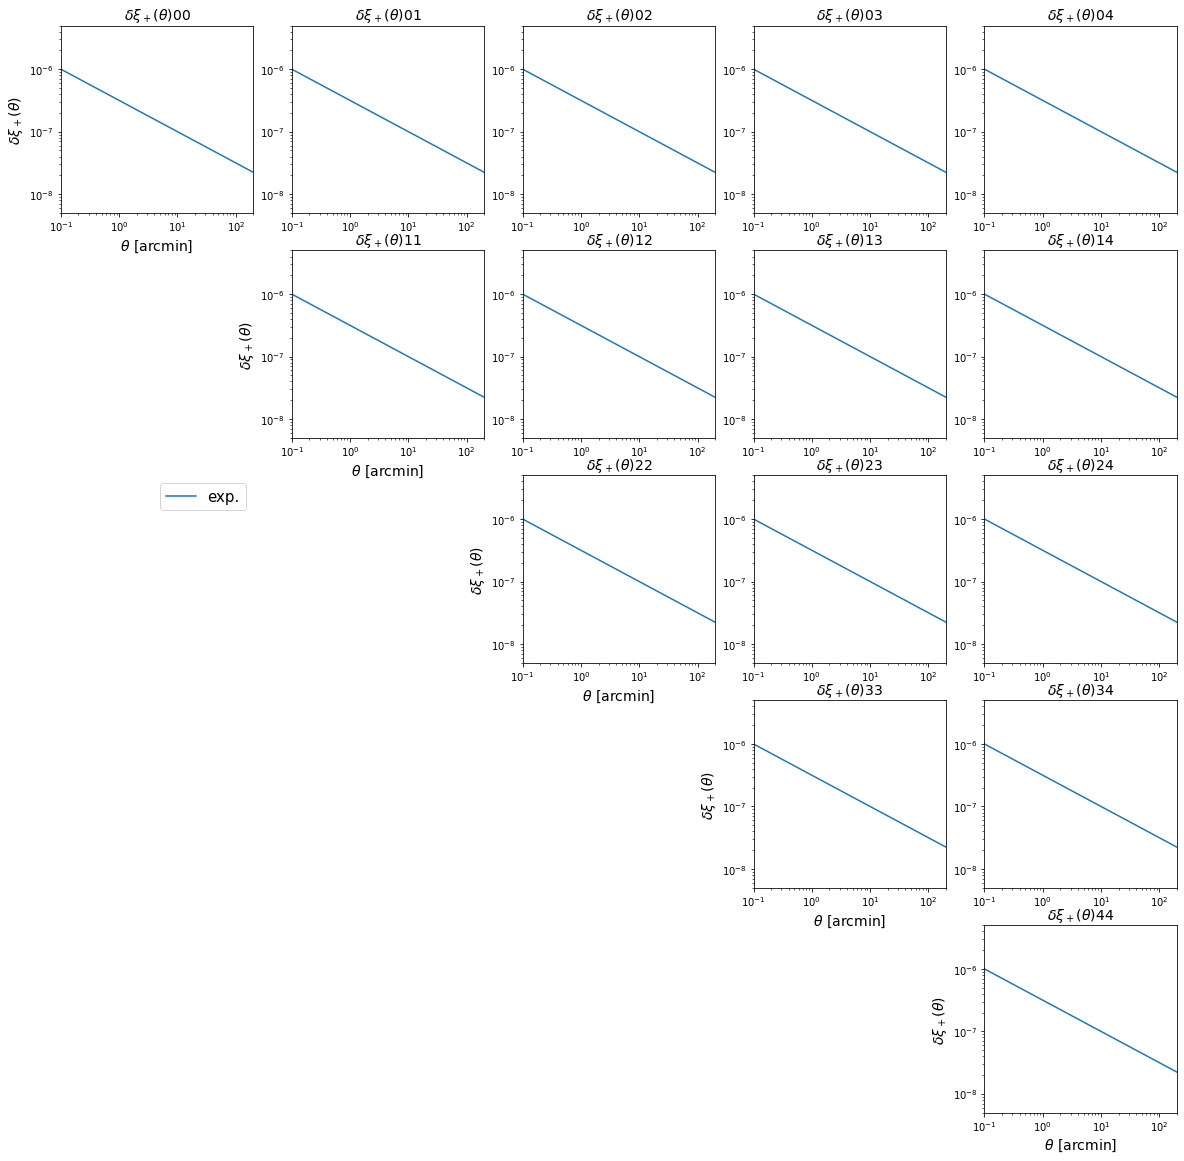

In [51]:
plt.figure(figsize = (20,20))

count = 0
for i in range(5):
    for j in range(i,5):
        #ell_fit = 
        plt.subplot(5,5,5*i+j+1)
        
        plt.plot(theta_rad*180/np.pi*60,xip_bias[0])
        plt.xlim(0.1, 200)
        plt.ylim(5e-9,5e-6)
        if j==i:
            plt.xlabel(r'$\theta$ [arcmin]')
            plt.ylabel(r'$\delta \xi_+ (\theta)$ ')
        
        
        count+=1
        plt.xscale('log')
        plt.yscale('log')
        
        plt.title(r'$\delta \xi_+ (\theta)$' + str(i)+str(j))

#         plt.fill_between([0,100], 0, 1, color = 'black',alpha = 0.1,edgecolor = 'white',linewidth=0.0)

        
plt.subplot(5,5,11)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.axis('off')
plt.plot([0],[0],label = 'exp.' )

plt.legend(fontsize = 15)
plt.show()

## Define some variables for calculating the shift: define the ell bins, parameter labels, parameter orders

In [20]:


lst = list(fiducial_fisher.dNdz_dict_source.keys())
ell = fiducial_fisher.ell
ell_0 = 20.0
ell_center = fiducial_fisher.ell
ell_bound = []
ell_bound.append(ell_0)
for i in range(15):
    ell_next = ell_center[i]**2/ell_bound[-1]
    ell_bound.append(ell_next)
#param_labels = [r'$\Omega_m$', r'$\sigma_8$', r'$n_s$', r'$w_0$', r'$w_a$', r'$\Omega_b$', r'$h$']+[r'$z_{bias}$'+str(i) for i in range(1, 6)] +[r'$\std{z}$']
param_labels = fiducial_fisher.param_labels
param_order = fiducial_fisher.param_order[0:11]






## Compute the parameter biases

In [25]:
# xip_bias1 = data2xip(lst, expconst, expconst_polys)



cell_bias = xip2cl(theta_rad, xip_bias, ell_bound)

para_bias = Cell2parambias(cell_bias, fiducial_fisher, param_order )
print(para_bias)



{'omega_m': 0.0038700910586856054, 'sigma_8': -0.003451553172394274, 'n_s': -0.002404174639127952, 'w_0': 0.04101036890547336, 'w_a': -0.07227488848001014, 'omega_b': 0.0003395547478030566, 'h': -0.004878220957629686, 'A0': -0.07422867718172112, 'beta': -0.0009963458447691512, 'etal': 0.0007878002067722929, 'etah': 0.00013742949873744905}


## Plot the additive bias on $C_\ell$

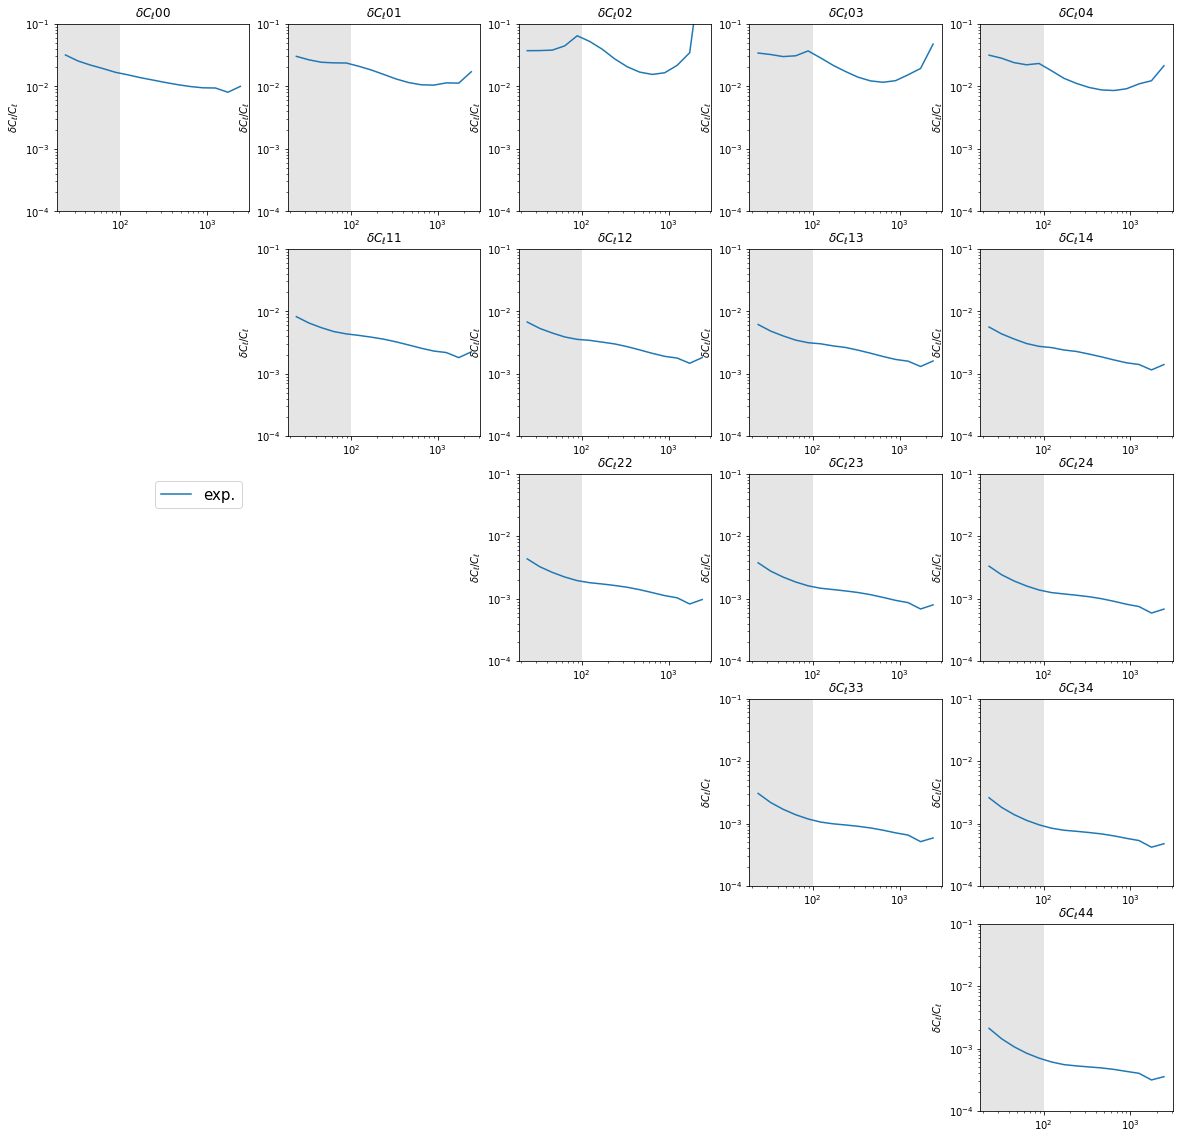

In [26]:
plt.figure(figsize = (20,20))
cl_unbiased = np.array(fiducial_fisher.ccl_cls['C_ell']).reshape(15, 15)

count = 0
for i in range(5):
    for j in range(i,5):
        #ell_fit = 
        plt.subplot(5,5,5*i+j+1)
        
        plt.plot(ell, cell_bias[count]/cl_unbiased[count], label = 'exp. ' )

        count+=1
        plt.xscale('log')
        plt.yscale('log')
        
        plt.title(r'$\delta C_\ell$' + str(i)+str(j))
        #plt.xlabel(r'$\ell$')
        plt.ylabel(r'$\delta C_\ell / C_\ell$')
        plt.ylim([0.0001,0.1])
        
        plt.fill_between([0,100], 0, 1, color = 'black',alpha = 0.1,edgecolor = 'white',linewidth=0.0)

        
plt.subplot(5,5,11)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.axis('off')
plt.plot([0],[0],label = 'exp.' )

plt.legend(fontsize = 15)
plt.show()

## Plot the parameter shift and print out the fiducial values, 1-sigma of the parameter, and the shift/sigma

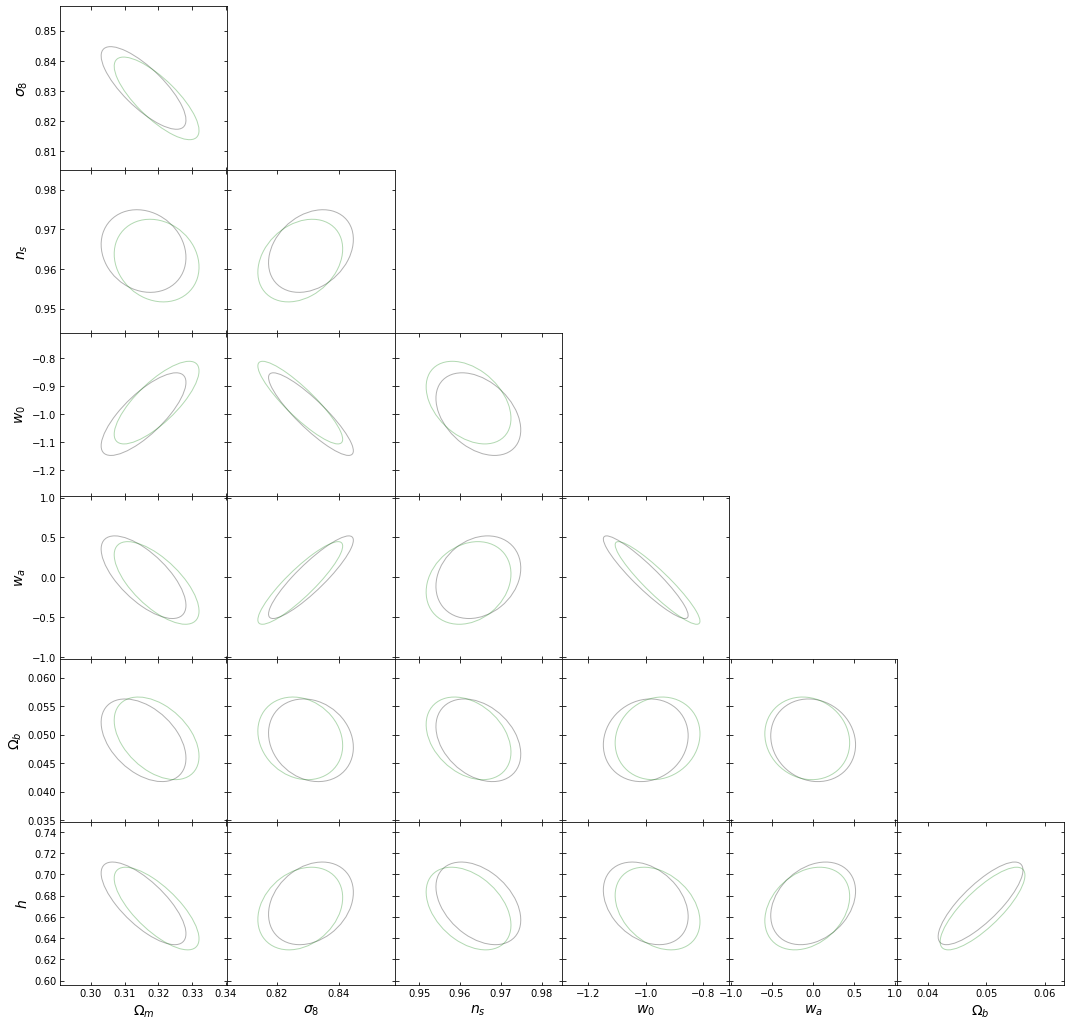


Fit by ***Exponential + const.***. 

Parameter       Fiducial Value  Sigma           Shift / Sigma  
omega_m         0.3156          0.0083          0.4681         
sigma_8         0.831           0.009           -0.3831        
n_s             0.9645          0.0068          -0.3511        
w_0             -1              0.0968          0.4235         
w_a             0               0.3414          -0.2117        
omega_b         0.049           0.0048          0.0711         
h               0.6727          0.0256          -0.1906        
average shift: 0.3716071279356787


In [35]:
plot_all_param(para_bias,fiducial_fisher)

print('Fit by ***Exponential + const.***. \n')

printoutshift(para_bias,fiducial_fisher)

# 2.0: Recalculate the fisher forecast at the new parameter point

## At the shifted new parameters, we compute the fisher forecast and the contours again. 

In [37]:
param_shift = dict()
for param in fiducial_fisher.param_order:
    param_shift[param] = fiducial_fisher.vals[param]

for param in para_bias.keys():
    param_shift[param] += para_bias[param]
    


nonlinear_shift_cosmo = ccl.Cosmology(Omega_c = param_shift['omega_m'] - param_shift['omega_b'],
                     Omega_b = param_shift['omega_b'],
                     h = param_shift['h'],
                     sigma8 = param_shift['sigma_8'],
                     n_s = param_shift['n_s'],
                     transfer_function = 'eisenstein_hu')
nonlinear_shift = Fisher(nonlinear_shift_cosmo)


nonlinear_shift.vals = param_shift
nonlinear_shift.A0 = param_shift['A0']

nonlinear_shift.process(cosmo = True)
print('Done')


Making Source Photo-z
Getting Ells
making C_ells
Getting covariance matrix
Getting derivatives
omega_m
sigma_8
n_s
w_0
w_a
omega_b
h
A0
beta
etal
etah
Building fisher matrix
Done
Done


## This is a function for ploting the fisher forecast for n fisher forecasts

In [47]:
def plot_n_fish(fishs,colors, labels):
    
    bias_ell = fishs[0].ell
    vals = []
    fishers = []
    covs = []
    
    for fish in fishs:
    
        vals.append(fish.vals)
        fishers.append(fish.fisher)
        covs.append(np.linalg.inv(fish.fisher))
        
    with open('../plots2/pickle/cosmology_parameter.pkl', 'wb') as output:
        pickle.dump([bias_ell,vals,fishers, covs,param_order, param_labels], output, pickle.HIGHEST_PROTOCOL)

    
    #colors = ['blue', 'red']

#     xlim_range = [[0.3,0.4],[-2.5,-0.75]]
#     ylim_range = [[0.6,0.85],[-1,4.0]]
    plt.rc('axes', titlesize=14)     # fontsize of the axes title
    plt.rc('axes', labelsize=14)    # fontsize of the x and y labels


    fig = plt.figure(figsize = (21,21))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.0)


    # for count, params in enumerate([['omega_m', 'sigma_8'],
    #                ['w_0', 'w_a']]):

    for row in range(7):
        for col in range(row+1,7):
            params = [param_order[row], param_order[col]]

            #biases = [para_bias[params[0]], para_bias[params[1]]]
            fid = [(vals[i][params[0]], vals[i][params[1]]) for i in range(len(fishs))]

            es = []

            index1 = param_order.index(params[0])
            index2 = param_order.index(params[1])
            
            #print(index1, index2,cov1[index1][index1])
            
#             my_xlim = [fid[0] - 2.5*np.sqrt(cov[index1][index1]) , fid[0] + 2.5*np.sqrt(cov[index1][index1])]
#             my_ylim = [fid[1] - 2.5*np.sqrt(cov[index2][index2]) , fid[1] + 2.5*np.sqrt(cov[index2][index2])]
            xlim_low = [fid[i][0] - 2.5* np.sqrt(covs[i][index1][index1]) for i in range(len(fishs))]
            xlim_high = [fid[i][0] + 2.5* np.sqrt(covs[i][index1][index1]) for i in range(len(fishs))]

            ylim_low = [fid[i][1] - 2.5* np.sqrt(covs[i][index2][index2]) for i in range(len(fishs))]
            ylim_high = [fid[i][1] + 2.5* np.sqrt(covs[i][index2][index2]) for i in range(len(fishs))]

            my_xlim = [np.min(xlim_low),np.max(xlim_high)]
            my_ylim = [np.min(ylim_low),np.max(ylim_high)]
            
            #print(my_xlim, my_ylim)

            for i, matrix in enumerate([fish.fisher for fish in fishs]):
                
                #print(matrix)
                e, (xlim, ylim) = plot_contours(marginalize(matrix, param_order.index(params[0]), param_order.index(params[1])),
                                  sigmas=1,
                                  fid=fid[i])
                e.set_edgecolor(colors[i])
                e.set_linewidth(1.5)
                e.set_facecolor('white')
                e.set_fill(False)
                #e.set_label(labels[i])
                e.set_alpha(0.8)
                es.append(e)
            ax = plt.subplot(7,7,7*col+row+1)
            subplot_number = 7*col+row+1

            for i, e in enumerate(es):
                ax.add_artist(e)

            ax.tick_params(
                axis='x',          # changes apply to the x-axis
                direction = 'in',
                which='both',      # both major and minor ticks are affected
                bottom=True,      # ticks along the bottom edge are off
                top=True,         # ticks along the top edge are off
                labelbottom=False)

            ax.tick_params(
                axis='y',          # changes apply to the x-axis
                direction = 'in',
                which='both',      # both major and minor ticks are affected
                left=True,      # ticks along the bottom edge are off
                right=True,         # ticks along the top edge are off
                labelleft=False)

            if subplot_number in list(range(43,49)):
                plt.xlabel(param_labels[param_order.index(params[0])])
                ax.tick_params(
                    axis='x',          # changes apply to the x-axis
                    direction = 'in',
                    which='both',      # both major and minor ticks are affected
                    bottom=True,      # ticks along the bottom edge are off
                    top=True,         # ticks along the top edge are off
                    labelbottom=True)
            if (subplot_number-1)%7==0:
                plt.ylabel(param_labels[param_order.index(params[1])])
                #plt.ticklabel_format(axis='y',style='scientific',scilimits=(0,3))
                ax.tick_params(
                    axis='y',          # changes apply to the x-axis
                    direction = 'in',
                    which='both',      # both major and minor ticks are affected
                    left=True,      # ticks along the bottom edge are off
                    right=True,         # ticks along the top edge are off
                    labelleft=True)
            #plt.title(str(subplot_number))
            #plt.xlim([-1.1, -0.9])
            plt.xlim(my_xlim)
            plt.ylim(my_ylim)
            #plt.legend(handles=es)
    
    plt.subplot(7,7,19)
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.axis('off')
    for i in range(len(colors)):
        ax.plot([0],[0],color = colors[i], linewidth = 1.5, alpha = 0.8,  label = labels[i] )

    ax.legend(fontsize = 15)


    plt.show()
            #plt.figure()

## Plot two fisher forecasts here

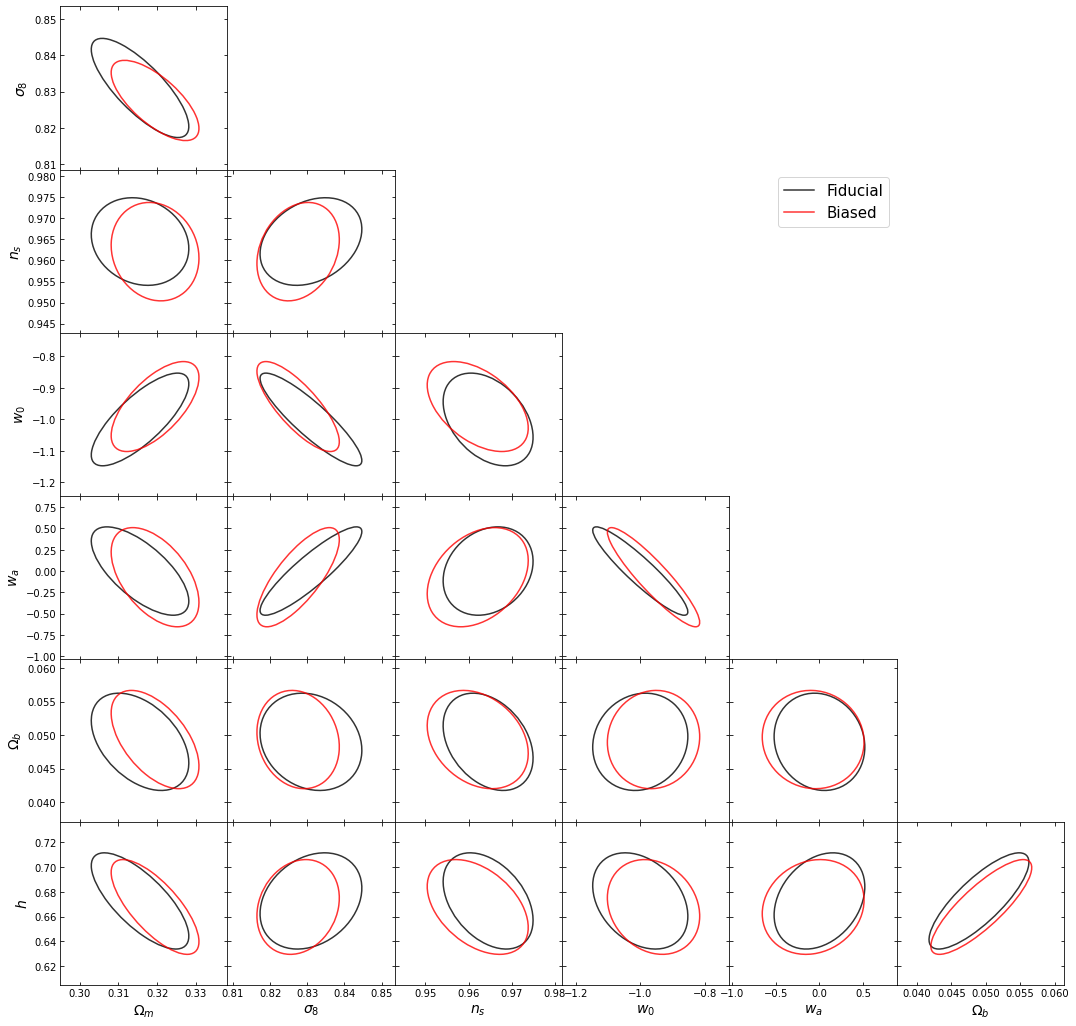

In [49]:
plot_n_fish([fiducial_fisher, nonlinear_shift], ['black','red' ], ['Fiducial', 'Biased'])
